In [1]:
import traceback
import matplotlib.pyplot as plt
import numpy as np

import time
import math

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def Rz(theta):
  
    return np.array([[  np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta),  np.cos(theta), 0 ],
                      [ 0            ,  0            , 1 ]])

# Apenas para visualização de um referencial no plano
def plot_frame(Porg, R, c=['r', 'g']):
    
    axis_size = 3.0    
    axes = axis_size*R
    
    x_axis = np.array(axes[0:2,0])
    y_axis = np.array(axes[0:2,1])
        
    # X
    plt.quiver(*Porg[:2], *x_axis, color=c[0], angles='xy', scale_units='xy', scale=1)
    
    # Y
    plt.quiver(*Porg[:2], *y_axis, color=c[1], angles='xy', scale_units='xy', scale=1)

In [4]:
class HokuyoSensorSim(object):
    """
    Simulates a Hokuyo laser sensor in CoppeliaSim using vision sensors.

    This class provides an interface to interact with a simulated Hokuyo sensor,
    typically attached to a robot in CoppeliaSim. It manages the underlying vision
    sensors and provides methods to retrieve sensor data in either range or point format.

    Attributes:
        _sim: The simulation API object used to interact with CoppeliaSim.
        _base_name (str): The name of the base object to which the Hokuyo sensor is attached.
        _is_range_data (bool): Determines if sensor data is returned as range values (True) or 3D points (False).
        _base_obj: The handle of the base object in the simulation.
        _vision_sensors_obj (list): Handles of the vision sensors used to simulate the Hokuyo sensor.

    Args:
        sim: The simulation API object.
        base_name (str): The name of the base object (must contain 'fastHokuyo').
        is_range_data (bool, optional): If True, sensor data is returned as range values. Defaults to False.

    Raises:
        ValueError: If 'fastHokuyo' is not in the base_name, or if the base object or vision sensors are not found.

    Methods:
        get_is_range_data() -> bool:
            Returns whether sensor data is returned as range values.

        set_is_range_data(is_range_data: bool) -> None:
            Sets whether sensor data should be returned as range values.

        getSensorData():
            Retrieves sensor data from the vision sensors.
            Returns either a list of range values or a list of 3D points, depending on _is_range_data.
    """

    _sim = None

    _base_name = ""
    _vision_sensor_name_template = "{}/sensor{}"

    # _vision_sensors_obj will be initialized in __init__
    _base_obj = None
    _is_range_data = False
    
    _angle_min=-120*math.pi/180
    _angle_max=120*math.pi/180
    _angle_increment=(240/684)*math.pi/180 # angle: 240 deg, pts: 684

    def __init__(self, sim, base_name, is_range_data=True):
        self._sim = sim
        self._base_name = base_name
        self._is_range_data = is_range_data

        if "fastHokuyo" not in base_name:
            raise ValueError(
                f"ERR: fastHokuyo must be in the base object name. Ex: `/PioneerP3DX/fastHokuyo`"
            )

        self._base_obj = sim.getObject(base_name)
        if self._base_obj == -1:
            raise ValueError(
                f"ERR: base_obj ({self._base_obj}) is not a valid name in the simulation"
            )

        self._vision_sensors_obj = [
            sim.getObject(self._vision_sensor_name_template.format(self._base_name, 1)),
            sim.getObject(self._vision_sensor_name_template.format(self._base_name, 2)),
        ]

        if any(obj == -1 for obj in self._vision_sensors_obj):
            raise ValueError(
                f"ERR: the _vision_sensors_obj names are not valid in the simulation"
            )

    def get_is_range_data(self) -> bool:
        return self._is_range_data

    def set_is_range_data(self, is_range_data: bool) -> None:
        self._is_range_data = is_range_data

    def getSensorData(self):
        
        angle = self._angle_min
        sensor_data = []
        
        for vision_sensor in self._vision_sensors_obj:
            r, t, u = sim.readVisionSensor(vision_sensor)
            if u:
                sensorM = sim.getObjectMatrix(vision_sensor)
                relRefM = sim.getObjectMatrix(self._base_obj)
                relRefM = sim.getMatrixInverse(relRefM)
                relRefM = sim.multiplyMatrices(relRefM, sensorM)

                p = [0, 0, 0]
                p = sim.multiplyVector(sensorM, p)
                t = [p[0], p[1], p[2], 0, 0, 0]
                for j in range(int(u[1])):
                    for k in range(int(u[0])):
                        w = 2 + 4 * (j * int(u[0]) + k)
                        v = [u[w], u[w + 1], u[w + 2], u[w + 3]]
                        angle = angle + self._angle_increment
                        if self._is_range_data:
                            sensor_data.append([angle, v[3]])
                        else:
                            p = sim.multiplyVector(relRefM, v)
                            sensor_data.append([p[0], p[1], p[2]])
                            
        return np.array(sensor_data)


    #Nova função que retorna os dados dos sensores com relação ao universo
    def getSensorDataUniverse(self):
        angle = self._angle_min
        sensor_data = []
        max_sensor_range=5
        
        for vision_sensor in self._vision_sensors_obj:
            r, t, u = sim.readVisionSensor(vision_sensor)
            if u:
                sensorM = sim.getObjectMatrix(vision_sensor) #Rus
                relRefM = sim.getObjectMatrix(self._base_obj) #Rur
                relRefMi = sim.getMatrixInverse(relRefM) #Rru
                relRefMi = sim.multiplyMatrices(relRefMi, sensorM) #Rru @ Rus = Rrs

                p = [0, 0, 0]
                p = sim.multiplyVector(sensorM, p)
                t = [p[0], p[1], p[2], 0, 0, 0]
                for j in range(int(u[1])):
                    for k in range(int(u[0])):
                        w = 2 + 4 * (j * int(u[0]) + k)
                        v = [u[w], u[w + 1], u[w + 2], u[w + 3]]

                        #if para filtrar quando não detectou nada
                        if (max_sensor_range - v[3]) > 0.1:
                            angle = angle + self._angle_increment
                            p = sim.multiplyVector(relRefM, sim.multiplyVector(relRefMi, v)) # Rru * Pr
                            sensor_data.append([p[0], p[1], p[2]])
                            
        return np.array(sensor_data)


In [5]:
def draw_laser_data_universe(laser_data):
    fig = plt.figure(figsize=(6,6), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    xs = laser_data[:,0]
    ys = laser_data[:,1]

    ax.scatter(xs, ys, s=2, c='r')
    
    #ax.plot(0, 0, 'k+', markersize=10)
        
    ax.grid(True)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_title("Leitura inicial do laser no referencial global")
    plt.axis("equal")
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.show()


Program started


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


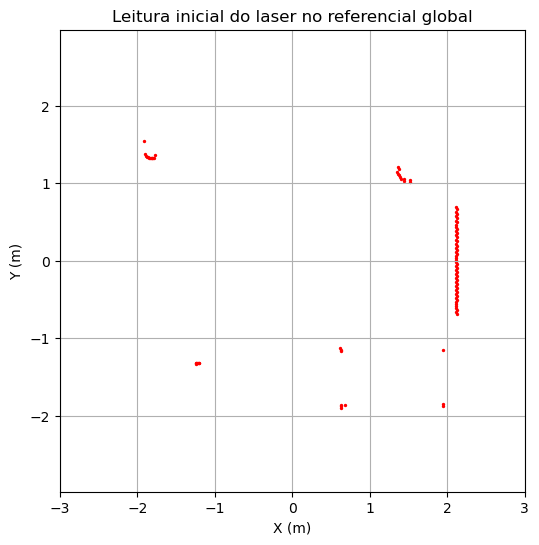

Initial Robot Position: [-1.9997874618447355, -0.7978274435027853, 0.13866154076426046]
Starting robot control loop...
Simulation time: 0.05 [s]
Simulation time: 0.10 [s]
Simulation time: 0.15 [s]
Simulation time: 0.20 [s]
Simulation time: 0.25 [s]
Simulation time: 0.30 [s]
Simulation time: 0.35 [s]
Simulation time: 0.40 [s]
Simulation time: 0.45 [s]
Simulation time: 0.50 [s]
Simulation time: 0.55 [s]
Simulation time: 0.60 [s]
Simulation time: 0.65 [s]
Simulation time: 0.70 [s]
Simulation time: 0.75 [s]
Simulation time: 0.80 [s]
Simulation time: 0.85 [s]
Simulation time: 0.90 [s]
Simulation time: 0.95 [s]
Simulation time: 1.00 [s]
Simulation time: 1.05 [s]
Simulation time: 1.10 [s]
Simulation time: 1.15 [s]
Simulation time: 1.20 [s]
Simulation time: 1.25 [s]
Simulation time: 1.30 [s]
Simulation time: 1.35 [s]
Simulation time: 1.40 [s]
Simulation time: 1.45 [s]
Simulation time: 1.50 [s]
Simulation time: 1.55 [s]
Simulation time: 1.60 [s]
Simulation time: 1.65 [s]
Simulation time: 1.70 [

In [7]:
#Exercicio 5

from coppeliasim_zmqremoteapi_client import RemoteAPIClient

print('Program started')
    
try:
    # Connect to the CoppeliaSim server
    client = RemoteAPIClient()
    sim = client.require("sim")
    sim.setStepping(True)

    # Handle para o ROBÔ
    robotname = 'PioneerP3DX'
    # The new API uses sim.getObject to get handles. The path starts with '/'
    robotHandle = sim.getObject('/' + robotname)
    
    # Handle para as juntas das RODAS
    l_wheel = sim.getObject('/' + robotname + '/leftMotor')
    r_wheel = sim.getObject('/' + robotname + '/rightMotor')
    
    # Parar a simulação se estiver executando
    initial_sim_state = sim.getSimulationState()
    if initial_sim_state != 0:
        sim.stopSimulation()
        time.sleep(1)
    
    # Inicia a simulação
    sim.startSimulation()
    sim.step()
 
    
    # Fazendo uma leitura do laser
    hokuyo_sensor = HokuyoSensorSim(sim, "/"+ robotname +"/fastHokuyo")
    initial_laser_data = hokuyo_sensor.getSensorDataUniverse()
    draw_laser_data_universe(initial_laser_data)
    
    # Posição inicial do robô
    pos = sim.getObjectPosition(robotHandle, sim.handle_world)
    print(f'Initial Robot Position: {pos}')
       
    # Dados do Pioneer
    L = 0.381  # Metros
    r = 0.0975 # Metros
    
    print("Starting robot control loop...")
    while (sim_time := sim.getSimulationTime()) < 5:
        print(f"Simulation time: {sim_time:.2f} [s]")
        
        # Fazendo leitura do laser
        laser_data = hokuyo_sensor.getSensorData()

        # Velocidade básica (linear, angular)
        v = 0
        w = np.deg2rad(0)

        frente = int(len(laser_data) / 2)
        lado_direito = int(len(laser_data) * 1 / 4)
        lado_esquerdo = int(len(laser_data) * 3 / 4)

        # Lógica de desvio de obstáculo
        if laser_data[frente, 1] > 2:
            v = .5
            w = 0
        elif laser_data[lado_direito, 1] > 2:
            v = 0
            w = np.deg2rad(-30)
        elif laser_data[lado_esquerdo, 1] > 2:
            v = 0
            w = np.deg2rad(30)

        # Modelo cinemático
        wl = v / r - (w * L) / (2 * r)
        wr = v / r + (w * L) / (2 * r)

        # Enviando velocidades (não precisa mais de opmode)
        sim.setJointTargetVelocity(l_wheel, wl)
        sim.setJointTargetVelocity(r_wheel, wr)

        sim.step()

    # Parando o robô
    print("Stopping robot...")
    sim.setJointTargetVelocity(r_wheel, 0)
    sim.setJointTargetVelocity(l_wheel, 0)

except Exception as e:
    print(f"An error occurred: {e}")
    
# Parando a simulação
sim.stopSimulation()

print('Program ended')

In [8]:
# Exercício 6

def draw_all_data_universe(laser_data, pos_hist):
    fig = plt.figure(figsize=(6,6), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    xs = laser_data[:,0]
    ys = laser_data[:,1]

    ax.scatter(xs, ys, s=2, c='r')

    x, y = zip(*pos_hist)
    ax.scatter(x, y)
    
    ax.plot(0, 0, 'k+', markersize=10)
        
    ax.grid(True)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_title("Leitura completa do laser e do caminho do robô no referencial global")
    plt.axis("equal")
    plt.show()

Program started
Initial Robot Position: [-1.9997874618447355, -0.7978274435027853, 0.13866154076426046]
Starting robot control loop...
An error occurred: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 1 has size 0
Program ended


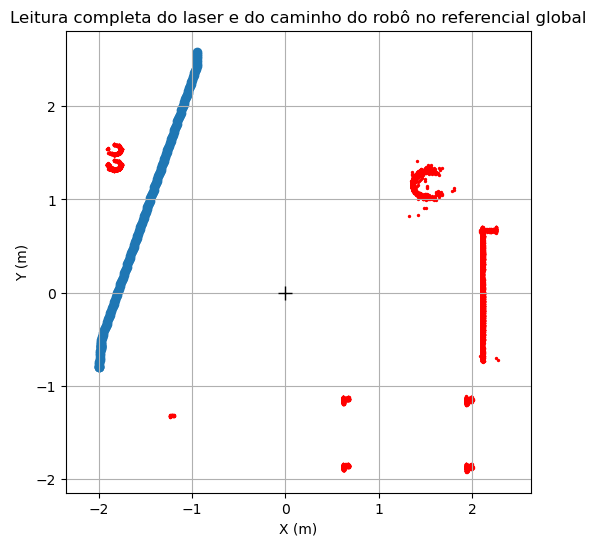

In [9]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

print('Program started')
    
try:
    # Connect to the CoppeliaSim server
    client = RemoteAPIClient()
    sim = client.require("sim")
    sim.setStepping(True)

    # Handle para o ROBÔ
    robotname = 'PioneerP3DX'
    # The new API uses sim.getObject to get handles. The path starts with '/'
    robotHandle = sim.getObject('/' + robotname)
    
    # Handle para as juntas das RODAS
    l_wheel = sim.getObject('/' + robotname + '/leftMotor')
    r_wheel = sim.getObject('/' + robotname + '/rightMotor')
    
    # Parar a simulação se estiver executando
    initial_sim_state = sim.getSimulationState()
    if initial_sim_state != 0:
        sim.stopSimulation()
        time.sleep(1)
    
    # Inicia a simulação
    sim.startSimulation()
    sim.step()
 
    
    # Fazendo uma leitura do laser
    hokuyo_sensor = HokuyoSensorSim(sim, "/"+ robotname +"/fastHokuyo")
    laser_data_plot = np.array(hokuyo_sensor.getSensorDataUniverse())
    
    # Posição inicial do robô
    pos_hist = []
    pos_hist.append(sim.getObjectPosition(robotHandle, sim.handle_world))
    print(f'Initial Robot Position: {pos}')
       
    # Dados do Pioneer
    L = 0.381  # Metros
    r = 0.0975 # Metros
    
    print("Starting robot control loop...")
    while (sim_time := sim.getSimulationTime()) < 20:
        #print(f"Simulation time: {sim_time:.2f} [s]")

        # Fazendo leitura do laser
        laser_data = hokuyo_sensor.getSensorData()

        # Velocidade básica (linear, angular)
        v = 0
        w = np.deg2rad(0)

        frente = int(len(laser_data) / 2)
        lado_direito = int(len(laser_data) * 1 / 4)
        lado_esquerdo = int(len(laser_data) * 3 / 4)

        # Lógica de desvio de obstáculo
        if laser_data[frente, 1] > 2:
            v = .5
            w = 0
        elif laser_data[lado_direito, 1] > 2:
            v = 0
            w = np.deg2rad(-30)
        elif laser_data[lado_esquerdo, 1] > 2:
            v = 0
            w = np.deg2rad(30)

        # Modelo cinemático
        wl = v / r - (w * L) / (2 * r)
        wr = v / r + (w * L) / (2 * r)

        # Enviando velocidades (não precisa mais de opmode)
        sim.setJointTargetVelocity(l_wheel, wl)
        sim.setJointTargetVelocity(r_wheel, wr)


        # Informações para o plot
        new_laser_data_plot = np.array(hokuyo_sensor.getSensorDataUniverse())
        laser_data_plot = np.vstack((laser_data_plot, new_laser_data_plot))

        position = sim.getObjectPosition(robotHandle, sim.handle_world)
        pos_hist.append([position[0], position[1]])
        
        sim.step()

        
    # Parando o robô
    print("Stopping robot...")
    sim.setJointTargetVelocity(r_wheel, 0)
    sim.setJointTargetVelocity(l_wheel, 0)

except Exception as e:
    print(f"An error occurred: {e}")
    
# Parando a simulação
sim.stopSimulation()

print('Program ended')

draw_all_data_universe(laser_data_plot, pos_hist)